Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [ ]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np
import rdkit
import sklearn

In [3]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data = loader.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [9]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0)

#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Eat"])

array([ 1.37878349,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  2.53953886,
       18.85475297,  4.28445705,  2.28445705,  2.28445705,  2.27005561,
        0.98559856,  0.98559856,  0.40824829,  0.40824829,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  6.42082162,
        6.9237372 ,  0.        ,  6.9237372 ,  0.        , 42.04695019,
        3.        ,  3.33333333,  3.33333333,  1.        ,  0.        ,
        3.        , 36.033     ,  1.37878349,  0.75      ,  0.125     ,
        0.        , 21.46913526,  2.39583333,  0.        ,  2.39583333,
        0.        ,  0.75      ,  0.        ,  0.75      ,  0.        ,
        1.3117    , 14.231     , 42.081     ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  2.        ,  0.  

In [135]:
#now run RFE to select the most important features 
from sklearn.feature_selection import RFE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor

selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=50, step = 20)
SelectedData = selector.fit_transform(Dataset.X, Dataset.y.ravel()) #y is a colum vector but it needs a 1d array -> ravel fixes this
selected = selector.support_ #this returns an array with true and false True are the selected features
ranks = selector.ranking_

In [136]:
#make a dataset with the new features
RFEDataset = dc.data.DiskDataset.from_numpy(X=SelectedData, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Eat"])

In [137]:
#find which descriptors are the most important
from rdkit.Chem import Descriptors
descriptors = Descriptors._descList

def Get_Selected_features(selected, ranks):
    from rdkit.Chem import Descriptors
    descriptors = Descriptors._descList

    for idx, bool in enumerate(selected):
        if bool == True:
            print(descriptors[idx][0],"is selected with rank:", ranks[idx])

Get_Selected_features(selected,ranks)

NumValenceElectrons is selected with rank: 1
NumRadicalElectrons is selected with rank: 1
MaxAbsPartialCharge is selected with rank: 1
FpDensityMorgan1 is selected with rank: 1
FpDensityMorgan2 is selected with rank: 1
FpDensityMorgan3 is selected with rank: 1
BCUT2D_MWHI is selected with rank: 1
BCUT2D_CHGHI is selected with rank: 1
BCUT2D_CHGLO is selected with rank: 1
BCUT2D_LOGPHI is selected with rank: 1
AvgIpc is selected with rank: 1
BalabanJ is selected with rank: 1
BertzCT is selected with rank: 1
Chi0n is selected with rank: 1
Chi1n is selected with rank: 1
Chi1v is selected with rank: 1
Chi3n is selected with rank: 1
Chi3v is selected with rank: 1
Chi4n is selected with rank: 1
HallKierAlpha is selected with rank: 1
Ipc is selected with rank: 1
Kappa1 is selected with rank: 1
Kappa3 is selected with rank: 1
PEOE_VSA1 is selected with rank: 1
PEOE_VSA11 is selected with rank: 1
PEOE_VSA13 is selected with rank: 1
PEOE_VSA2 is selected with rank: 1
PEOE_VSA4 is selected with r

In [138]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(RFEDataset)
print("Data is splitted into: train and test")

Data is splitted into: train and test


In [139]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor( kernel = kernel, n_restarts_optimizer=20))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")


fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted


In [140]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999999999953}
Test set score: {'pearson_r2_score': 0.9716305586549537}


In [141]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_squared_error': 5.314034107061791e-16}
Test set score: {'mean_squared_error': 0.0036389925010167946}


In [142]:
#calculate MAE score
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
print('Training set score:', model.evaluate(train_dataset, metric))
print('Test set score:', model.evaluate(test_dataset, metric))

Training set score: {'mean_absolute_error': 3.925418770660663e-09}
Test set score: {'mean_absolute_error': 0.038309395623496736}


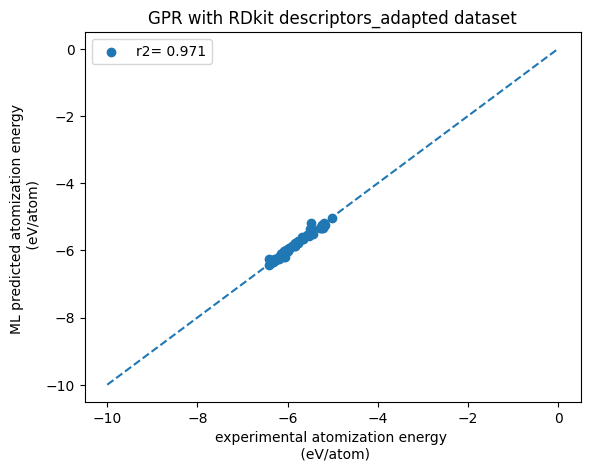

In [145]:
#plot the data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#predict the r2_score and convert to string
predicted = model.predict(test_dataset)
score =r2_score(test_dataset.y, predicted)
text = "r2= "+ str(round(score,3))

x=[-10,0]
y=[-10,0]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental atomization energy \n (eV/atom)")
plt.ylabel("ML predicted atomization energy \n (eV/atom)")
plt.title("GPR with RDkit descriptors_adapted dataset")
plt.show()
